In [1]:
import pandas as pd

df01 = pd.read_csv(r'data/origin2/ex/0000049.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
df01

,Num,X,Y,Dist
0,288,-37.260057,1.590264,NaN
1,290,-87.464993,0.486055,NaN
2,290a,-113.275301,-0.236772,NaN
3,291,-138.192597,-6.314558,NaN
4,289,-62.139730,-4.491305,NaN
5,287,-12.198468,-3.385491,NaN
6,285,37.835882,-2.156479,NaN
7,283,86.824013,-0.952729,NaN
8,281,136.753554,0.107044,NaN
9,282,111.705384,5.104427,NaN


In [2]:
df02 = pd.read_csv(r'data/origin2/ex/0000050.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
df02

,Num,X,Y,Dist
0,292,-12.617737,2.138001,NaN
1,294,-62.697316,0.972803,NaN
2,296,-112.827931,-0.210242,NaN
3,297,-138.885729,-6.322612,NaN
4,295,-87.828376,-5.189919,NaN
5,293,-37.632754,-3.966090,NaN
6,291,12.311738,-2.774219,NaN
7,289,88.364249,-0.949701,NaN
8,287,138.305905,0.157217,NaN
9,288,113.243732,5.132866,NaN


Дополнительный шаг - выборка номер одинаковых номеров пунктов.
Сортирую номера и записи в таблицы, надеюсь, что принцип сортировки и в сете и в дф одинаковые, но лучше будет убедиться.

In [3]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))
df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

In [4]:
inter
         

['287', '288', '289', '290', '290a', '291']

Создаю по два набора точек - mp01,mp02 - все точки, включая стоянки. mp01_c, mp02_c - набор общих точек.

In [5]:
from shapely.geometry import MultiPoint

mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

def plp(z,n):
    for p in z:        
        x = [i.x for i in p.geoms]
        y = [i.y for i in p.geoms]
        plt.figure(n)
        plt.plot(x,y,'ro')
        plt.plot(x,y,'ro')
    plt.show()

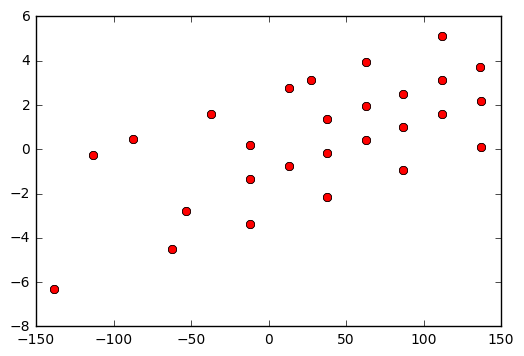

In [7]:
plp((mp01,),0)

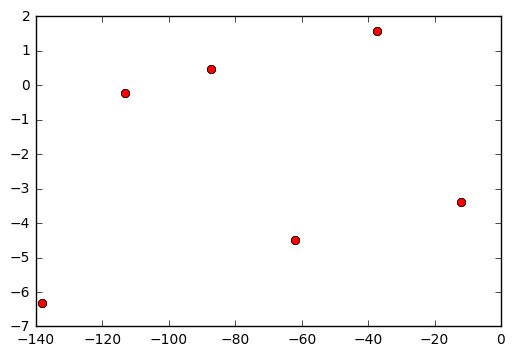

In [8]:
plp((mp01_c,),1)

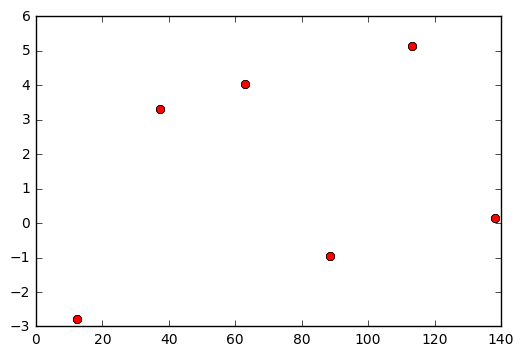

In [9]:
plp((mp02_c,),1)

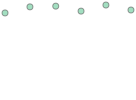

In [10]:
mp02_c

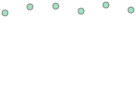

In [11]:
mp01_c

In [12]:
from shapely import affinity
from scipy.optimize import minimize,rosen_der

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

In [13]:
x0 = (0,0,0)

In [14]:
re = minimize(fun1,x0,args=(mp01_c[1:4],mp02_c[1:4]),method='BFGS')
re

      fun: 0.0005503683549343233
 hess_inv: array([[  5.60361263e-05,   2.65069537e-05,   7.54031898e-06],
       [  2.65069537e-05,   5.97350527e-05,  -3.70100947e-05],
       [  7.54031898e-06,  -3.70100947e-05,   3.66693434e-05]])
      jac: array([ 0.06736879,  0.02331537,  0.03040687])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 581
      nit: 28
     njev: 114
   status: 2
  success: False
        x: array([ -1.50503921e+02,  -3.54044386e+00,  -1.08230313e-03])

In [15]:
mp_moved = mov(x,y,angle,mp02)
mp_moved

NameError: name 'x' is not defined

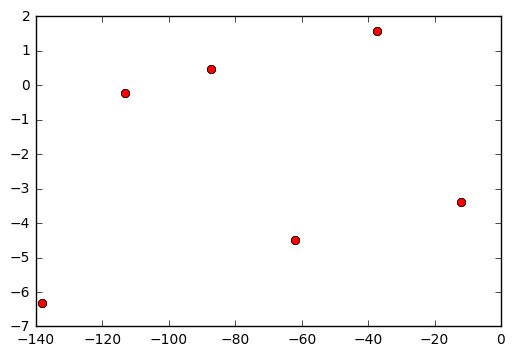

In [16]:
plp((mp01_c,),7)

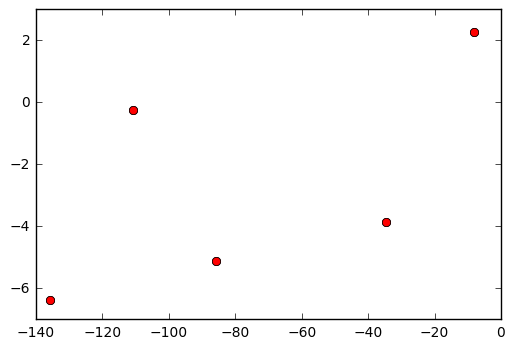

In [201]:
plp((mov(x,y,angle,mp02_c),),6)

Считаем расстояния от стоянки 99002 до всех точек.  
До сдвижки, после сдвижки, значение сдвижки.

In [143]:
dist_do = [mp02[-1].distance(i) for i in mp02]
dist_po = [mp_moved[-1].distance(i) for i in mp_moved]
od = zip(dist_do,dist_po)
od = [[i[0],i[1],i[0]-i[1]] for i in od]
df_od = pd.DataFrame.from_records(od,columns=('Before','After','Diff'))
df_od

,Before,After,Diff
0,3.564887,3.564887,0.000000e+00
1,25.171929,25.171929,3.552714e-15
2,25.100289,25.100289,-2.131628e-14
3,75.545138,75.545138,-1.421085e-14
4,125.038498,125.038498,-2.842171e-14
5,100.085424,100.085424,0.000000e+00
6,100.085422,100.085422,-2.842171e-14
7,50.306531,50.306531,-1.421085e-14
8,49.762246,49.762246,7.105427e-15
9,100.068214,100.068214,0.000000e+00


Расстояние между всеми точками:

In [144]:
all_l = []
for origin in mp02:
    nap = []
    for p in mp02:
        nap.append(origin.distance(p))
    all_l.append(nap)

all_2 = []
for origin in mp_moved:
    nap = []
    for p in mp_moved:
        nap.append(origin.distance(p))
    all_2.append(nap)

all_a = [list(zip(i[0],i[1])) for i in list(zip(all_l,all_2))]
all_a

[[(0.0, 0.0),
  (25.8194057615326, 25.819405761532625),
  (25.51928184340495, 25.519281843404944),
  (75.60527880362842, 75.6052788036284),
  (125.02727607828821, 125.0272760782882),
  (99.90276290795009, 99.90276290795008),
  (99.90276640356217, 99.90276640356215),
  (50.06120096860941, 50.061200968609405),
  (49.761904803991214, 49.76190480399123),
  (100.12832551888907, 100.1283255188891),
  (124.7335867192756, 124.73358671927562),
  (75.3891790953455, 75.38917909534553),
  (150.369238761457, 150.369238761457),
  (150.45124307415364, 150.45124307415364),
  (125.05192890314973, 125.05192890314972),
  (124.99463616216477, 124.99463616216475),
  (100.02210709736875, 100.02210709736875),
  (100.09784022740449, 100.09784022740448),
  (75.57384727190075, 75.57384727190072),
  (75.52214911046778, 75.52214911046777),
  (75.05761234947116, 75.05761234947114),
  (50.063456491533415, 50.063456491533394),
  (50.15709867736658, 50.15709867736656),
  (25.23868685691421, 25.238686856914192),
  (25

Таблица с координатам сдвинутого 99002:

In [146]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df



,Num,X,Y,Dist
0,444,-160.250877,-1.380129,3.564887
1,445,-185.320136,-7.558635,25.171929
2,443,-135.224595,-6.372020,25.100289
3,441,-84.739406,-5.145234,75.545138
4,439,-35.249816,-3.940299,125.038498
5,438,-60.377078,1.025356,100.085424
6,440,-60.377071,1.025211,100.085422
7,442,-110.204115,-0.177856,50.306531
8,446,-209.995492,-2.691787,49.762246
9,448,-260.347169,-3.912704,100.068214


Координаты 99001:

In [71]:
df01

,Num,X,Y,Dist
0,20,-8.660718,3.106462,NaN
1,22,-28.990161,3.747231,NaN
2,24,-84.429092,5.460118,NaN
3,25,-109.996486,0.344068,NaN
4,23,-59.318024,-0.941319,NaN
5,21,-11.044253,-2.162972,NaN
6,19,7.883008,-3.063069,NaN
7,17,57.229627,-4.465531,NaN
8,15,83.030155,-5.084494,NaN
9,14,106.386369,0.001604,NaN


Оригинальные координаты 990002:

In [72]:
df02

,Num,X,Y,Dist
0,26,-10.340730,2.554477,NaN
1,28,-59.204688,1.595030,NaN
2,29,-90.283492,0.614403,NaN
3,30,-111.348544,-5.354379,NaN
4,29a,-90.106648,-5.159582,NaN
5,27,-27.537217,-3.404122,NaN
6,25,8.584244,-2.743366,NaN
7,23,59.259360,-1.339418,NaN
8,21,-53.765223,-93.123585,NaN
9,20,109.630899,5.389003,NaN


In [73]:
df_stag = zip(df01.itertuples(),mov_df.itertuples())
list(df_stag)
staging = [[i[0][0],i[0][1],i[0][2],i[1][2],i[0][2]-i[1][2],i[0][3],i[1][3],i[0][3]-i[1][3],i[0][4],i[1][4],i[0][4]-i[1][4]] for i in list(df_stag)]

In [74]:
zz =  pd.concat([df01,mov_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()
zz

,Num,X,Y,Dist
0,14,106.386369,0.001604,0.000000
1,15,83.030155,-5.084494,0.000000
2,16,57.482335,1.323236,0.000000
3,17,57.229627,-4.465531,0.000000
4,18,31.073248,1.825374,0.000000
5,19,7.883008,-3.063069,0.000000
6,20,-8.660629,3.107361,75.805036
7,21,-177.049314,-86.604806,130.592870
8,22,-28.989881,3.747656,55.465706
9,23,-59.318024,-0.941319,25.914278


In [75]:
df01 = zz
df02 = pd.read_csv(r'data/chain/105.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
df02

FileNotFoundError: File b'data/chain/105.csv' does not exist

In [125]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

In [126]:
mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

In [130]:
x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')

re

     fun: 0.00426196957177334
     jac: array([  -1.21600761,    1.9712386 , -560.31175013,    0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 498
     nit: 88
    njev: 88
  status: 0
 success: True
       x: array([ -494.04349035,  3402.32346331,    13.98854554])

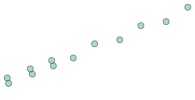

In [131]:
mp_moved = mov(*re.x,mp02)
mp_moved

In [132]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df

,Num,X,Y,Dist
0,609,-14508.085613,-446.117557,75.313632
1,608,-14486.660032,-431.841115,49.955337
2,610,-14529.792545,-448.635295,96.241950
3,611,-14549.225133,-462.265510,119.435671
4,612,-14574.382649,-466.186257,144.161730
5,610a,-14528.056404,-454.027120,96.753435
6,611a,-14551.228058,-457.041346,119.266772
7,612a,-14573.031527,-471.629786,144.996283
8,607,-14461.388582,-427.842827,25.570046
9,605,-14414.776804,-409.600672,25.691876


In [133]:
zz =  pd.concat([df01,mov_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()
zz

,Num,X,Y,Dist
0,593,-14133.887400,-299.583600,0.000000
1,594,-14159.244600,-303.605200,0.000000
2,595,-14180.551200,-317.862700,0.000000
3,596,-14205.796800,-321.824000,0.000000
4,597,-14227.175700,-336.142800,0.000000
5,597a,-14229.019800,-330.917400,0.000000
6,598,-14252.268910,-340.045658,51.162629
7,599,-14274.391879,-354.624764,25.844611
8,600,-14299.915662,-358.684370,0.000000
9,601,-14321.163836,-372.931709,25.582642


In [134]:
df01 = zz
df02 = pd.read_csv(r'data/chain/106.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')
mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])
x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')
mp_moved = mov(*re.x,mp02)

In [137]:
re

     fun: 4.236177418337145
     jac: array([   1.99254447,   -0.40828776,  221.74558228,    0.        ])
 message: 'Iteration limit exceeded'
    nfev: 545
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([ -405.84391151,  3067.52073644,    12.65462041])

In [138]:
inter

['610', '610a', '611', '611a', '612', '612a']

In [136]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df

,Num,X,Y,Dist
0,612,-14574.506644,-465.178297,24.894722
1,611,-14549.211001,-462.285522,5.594790
2,613,-14596.914747,-478.751945,50.814175
3,614,-14620.621286,-481.361715,73.766592
4,615,-14643.239990,-494.780231,99.684099
5,613a,-14599.453386,-473.751012,51.273215
6,614a,-14619.703802,-486.664942,74.841707
7,615a,-14639.901496,-488.013992,94.161997
8,612a,-14573.378611,-470.672027,26.233544
9,610a,-14527.723964,-454.916681,23.366804


g